In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from pyinform import transfer_entropy


def effective_transfer_entropy(X, Y, k=1, shuffles=500):
    x = X.copy()
    y = Y.copy()
    TE_xy = transfer_entropy(x, y, k=1)
    TE_xy_s = 0
    for i in range(shuffles):
        np.random.shuffle(x)
        TE_xy_s += transfer_entropy(x, y, k=1)
    TE_xy_s /= shuffles
    
    return TE_xy - TE_xy_s

def calculate_te(X, Y, s=1, omega=28, delta=14, k=1, ETE=False, shuffles=500, **kargs):
    
    L = Y.shape[0]
    N = L - (omega + delta) + 1
    n_points = int( N / s )
    TE = np.zeros(n_points)
        
    # Filter self loops
    if source == target: 
        return (source, target, TE)
    # Speed-up to avoid calculating cases where there is no risk between i and j
    
    for j,i in enumerate(range(0, n_points, s)):
        x = X[i:i+omega]
        y = Y[i+delta:i+delta+omega]
        if ETE:
            TE[j] = effective_transfer_entropy(x, y, k=k, shuffles=shuffles)
        else:
            TE[j] = transfer_entropy(x, y, k)
   
    return TE

In [2]:

base_folder = "../results/TE_cnig_provincias/"
cases_fname = os.path.join(base_folder, "cases_pop_ds.nc")
risk_ij_fname = os.path.join(base_folder, "risk_ds.nc")

cases_ds = xr.load_dataset(cases_fname)
risk_ds = xr.load_dataset(risk_ij_fname)

In [3]:


risk_ij = risk_ds['risk_ij']
trips_ij = risk_ds['trips_ij']

risk_ij_dt = risk_ij.diff('date')
trips_ij_dt = trips_ij.diff('date')

cases_by_100k = cases_ds['new_cases_by_100k']
cases_by_100k_dt = cases_by_100k.diff('date')

dates = risk_ij_dt.coords['date']


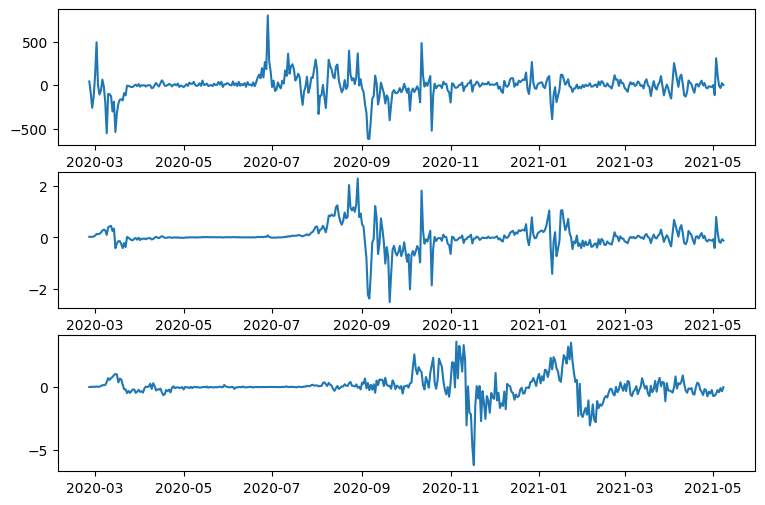

In [4]:
source = "28"
target = "33"

fig, axes = plt.subplots(3, 1, figsize=(9,6))

Z = trips_ij_dt.loc[source, target, :].to_pandas()
axes[0].plot(Z[10:])

X = risk_ij_dt.loc[source, target, :].to_pandas()
axes[1].plot(X[10:])
# X = risk_ij_dt.loc[target, source, :].to_pandas()
# axes[1].plot(X[10:], c='r')

Y = cases_by_100k_dt.loc[target, :].to_pandas()
axes[2].plot(Y[10:])
# Y = cases_by_100k_dt.loc[source, :].to_pandas()
# axes[2].plot(Y[10:])

plt.show()

In [5]:
my_digitize = lambda x,bins: np.digitize(x, bins, right=False)

source = "28"
target = "19"

source = "08"
target = "07"

source = "28"
target = "33"

data = risk_ij_dt.values.flatten()
bins = np.quantile(data, [0.001, 0.05, 0.95, 0.999])
bins = np.quantile(data, [0.1, 0.2, 0.8, 0.9])
bins = [-2,-1,1,2]
X_risk_ij_dt = xr.apply_ufunc(my_digitize, risk_ij_dt, bins)

data = cases_by_100k_dt.values.flatten()
bins = np.quantile(data, [0.001, 0.2, 0.8, 0.999])
bins = np.quantile(data, [0.1, 0.2, 0.8, 0.9])
bins = [-2,-1,1,2]
Y_cases_by_100k_dt = xr.apply_ufunc(my_digitize, cases_by_100k_dt, bins)

d = 28
X = X_risk_ij_dt.loc[source, target, :].to_pandas()
Y = Y_cases_by_100k_dt.loc[target, :].to_pandas()
X = X[:-d]
Y = Y[d:]
print(f"TE  {source} -> {target}", transfer_entropy(X.values, Y.values, k=1))
print(f"ETE {source} -> {target}", effective_transfer_entropy(X.values, Y.values))

print()

X = X_risk_ij_dt.loc[target, source, :].to_pandas()
Y = Y_cases_by_100k_dt.loc[source, :].to_pandas()
X = X[:-d]
Y = Y[d:]
print(f"TE  {target} -> {source}", transfer_entropy(X.values, Y.values, k=1))
print(f"ETE {target} -> {source}", effective_transfer_entropy(X.values, Y.values))

TE  28 -> 33 0.0435266602474553
ETE 28 -> 33 0.01845166090837158

TE  33 -> 28 0.0
ETE 33 -> 28 0.0


TE  28 -> 33 0.022727318412447302
ETE 28 -> 33 0.010356500783344462
TE  33 -> 28 0.0
ETE 33 -> 28 0.0


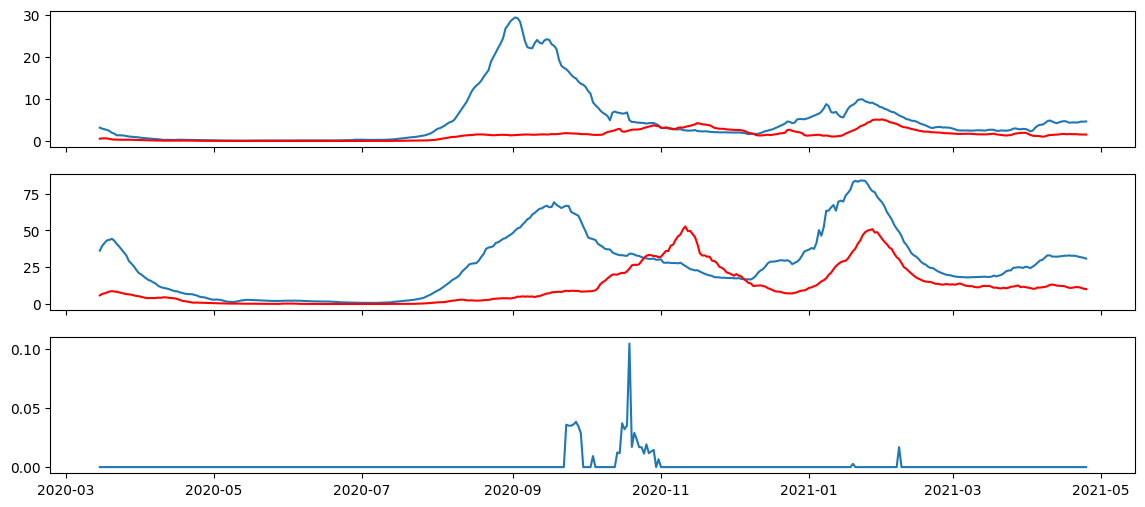

In [14]:
source = "28"
target = "33"

use_ETE = True
omega = 28
delta = 14

bins = [-1.,  1.]
# quantiles = [0.05, 0.95]

# data = risk_ij_dt.loc[[source,target],[source,target],:].values.flatten()
# bins = np.quantile(data, quantiles)
X_risk_ij_dt = xr.apply_ufunc(my_digitize, risk_ij_dt, bins)

# data = cases_by_100k_dt.loc[[source,target], :].values.flatten()
# bins = np.quantile(data, quantiles)
Y_cases_by_100k_dt = xr.apply_ufunc(my_digitize, cases_by_100k_dt, bins)

X = X_risk_ij_dt.loc[source, target, :].to_pandas().values
Y = Y_cases_by_100k_dt.loc[target, :].to_pandas().values
print(f"TE  {source} -> {target}", transfer_entropy(X[:-omega], Y[omega:], k=1))
print(f"ETE {source} -> {target}", effective_transfer_entropy(X[:-omega], Y[omega:]))

TE_xy = calculate_te(X, Y, omega=omega, delta=delta, ETE=use_ETE)
TE_xy[TE_xy<0] = 0

X = X_risk_ij_dt.loc[target, source, :].to_pandas().values
Y = Y_cases_by_100k_dt.loc[source, :].to_pandas().values
print(f"TE  {target} -> {source}", transfer_entropy(X[:-omega], Y[omega:], k=1))
print(f"ETE {target} -> {source}", effective_transfer_entropy(X[:-omega], Y[omega:]))

TE_yx = calculate_te(X, Y, omega=omega, delta=delta, ETE=use_ETE)
TE_yx[TE_yx<0] = 0

start = int(omega)
TE_dates = dates[start:]
end = min(len(TE_dates), TE_xy.shape[0])
TE_dates = TE_dates[:end]


fig, axes = plt.subplots(3, 1, figsize=(14,6), sharex=True)
axes[0].plot(risk_ij.loc[source, target, TE_dates].to_pandas())
axes[0].plot(risk_ij.loc[target, source, TE_dates].to_pandas(), c='r')

axes[1].plot(cases_by_100k.loc[source, TE_dates].to_pandas())
axes[1].plot(cases_by_100k.loc[target, TE_dates].to_pandas(), c='r')


DIxy = TE_xy - TE_yx
# DIxy[np.abs(DIxy) < 1e-4] = 0
axes[2].plot(TE_dates, DIxy)

plt.show()

In [8]:
# Discretize based on quantiles
def kde_quantile_discretization(arr, n_quantiles=5):
    discretizer = KBinsDiscretizer(n_bins=n_quantiles, encode='ordinal', strategy='quantile')
    quantile_indices = discretizer.fit_transform(arr.reshape(-1, 1)).astype(int)
    return quantile_indices.ravel()

# X_enc = kde_quantile_discretization(X, n_quantiles=5)

# Apply the function across the last dimension
# discretized_data = xr.apply_ufunc(kde_quantile_discretization,
#                                   ds,
#                                   input_core_dims=[['dim_2']],
#                                   kwargs={'n_quantiles': 10},  # Set quantile number here
#                                   vectorize=True)



In [17]:
XX = xr.load_dataarray("../outputs/TE_cnig_provincias/run_ETE_w28_d14_S_Q1_-1_Q2_1_risk_ij/X.nc")
YY = xr.load_dataarray("../outputs/TE_cnig_provincias/run_ETE_w28_d14_S_Q1_-1_Q2_1_risk_ij/Y.nc")

A = XX.loc[source, target, :].values
B = X_risk_ij_dt.loc[source, target, :].values
print((A != B).sum())

A = YY.loc[target, :].values
B = Y_cases_by_100k_dt.loc[target, :].values
print((A != B).sum())


TE = xr.load_dataarray("../outputs/TE_cnig_provincias/run_ETE_w28_d14_S_Q1_-1_Q2_1_risk_ij/TE.nc")

# TE.loc[source, target, :].values

TE_xy

0
0


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [10]:
X = XX.loc[source, target, :].to_pandas().values
Y = YY.loc[target, :].to_pandas().values
print(f"TE  {source} -> {target}", transfer_entropy(X[:-omega], Y[omega:], k=1))
print(f"ETE {source} -> {target}", effective_transfer_entropy(X[:-omega], Y[omega:]))

TE_xy = calculate_te(X, Y, omega=omega, delta=delta, ETE=use_ETE)
TE_xy[TE_xy<0] = 0

X = XX.loc[target, source, :].to_pandas().values
Y = YY.loc[source, :].to_pandas().values
print(f"TE  {target} -> {source}", transfer_entropy(X[:-omega], Y[omega:], k=1))
print(f"ETE {target} -> {source}", effective_transfer_entropy(X[:-omega], Y[omega:]))

TE_yx = calculate_te(X, Y, omega=omega, delta=delta, ETE=use_ETE)
TE_yx[TE_yx<0] = 0

# start = int(omega)
# TE_dates = dates[start:]
# end = min(len(TE_dates), TE_xy.shape[0])
# TE_dates = TE_dates[:end]


# fig, axes = plt.subplots(3, 1, figsize=(14,6), sharex=True)
# axes[0].plot(risk_ij.loc[source, target, TE_dates].to_pandas())
# axes[0].plot(risk_ij.loc[target, source, TE_dates].to_pandas(), c='r')

# axes[1].plot(cases_by_100k.loc[source, TE_dates].to_pandas())
# axes[1].plot(cases_by_100k.loc[target, TE_dates].to_pandas(), c='r')


# DIxy = TE_xy - TE_yx
# # DIxy[np.abs(DIxy) < 1e-4] = 0
# axes[2].plot(TE_dates, DIxy)

# plt.show()

TE  28 -> 33 0.022727318412447302
ETE 28 -> 33 0.009798964154141923
TE  33 -> 28 0.0
ETE 33 -> 28 0.0
